# Bisender  Multiple Access Channel Nonlocality and Capacity

This notebook explores the capacity and of nonlocal correlations found for quantum bisender multiple access channels where each sender can use one qubit (or bit) of communication.

In [4]:
from context import QNetOptimizer as QNopt
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

### Linear Inequalities Bounding Bisender MAC

In [5]:
mac_bound_inequalities = [
    (np.array([[0,0,0,0,1,0,1,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,1,0,1,0,0,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,0,0,0,1,1,0,0],[1,1,0,1,0,0,0,1,0]]), 5),
    (np.array([[0,0,0,0,1,0,0,0,1],[1,1,0,1,0,1,0,0,0]]), 5),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,1,0,1,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,2,0,1,0,0,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,2,0,1,0,0,0]]), 7),
    (np.array([[0,0,0,0,1,1,1,0,1],[1,1,0,1,0,0,0,1,0]]), 6),
    (np.array([[0,0,0,0,1,1,2,0,0],[2,2,0,1,0,0,0,1,0]]), 8),
    (np.array([[0,0,0,0,2,0,1,0,1],[2,2,0,1,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,0,0,1,0]]), 8),
    (np.array([[0,0,1,0,1,0,2,0,0],[2,1,0,0,0,1,0,2,0]]), 8),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,1,0,0,0]]), 10),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,0,0,1,0]]), 10),
    (np.array([[0,0,2,0,1,0,2,0,0],[3,1,0,1,0,2,0,2,0]]), 11),
    (np.array([[0,0,2,0,2,0,2,0,0],[3,1,0,1,0,3,0,3,1]]), 14),
    (np.array([[0,0,2,0,3,0,2,0,1],[5,3,0,3,0,1,0,1,0]]), 16),
    (np.array([[0,0,2,1,2,0,5,0,1],[4,2,0,0,0,1,0,4,0]]), 17),
]

### Helper Functions for Rate Region Evaluation

In [38]:
def priors_scan_range(num_steps):
    eps = 1e-10
    x1_range = np.arange(0,1+eps,1/num_steps)

    priors = []
    for x1 in x1_range:
        x2_range = np.arange(0,1-x1+eps,1/num_steps)
        for x2 in x2_range:
            priors.append(np.array([x1,x2,1-x1-x2]))
        
    return priors

def plot_rate_region(rate_tuple):
    r1, r2, r_sum = rate_tuple
    
    r1_vals = [0,0,r_sum-r2,r1,r1,0]
    r2_vals = [0,r2,r2,r_sum-r1,0,0]
    
    plt.plot(r1_vals, r2_vals,"b-",label="Quantum")
    plt.plot([0,0,1,0],[0,1,0,0],"r--",label="Classical")
    plt.legend()
    plt.title("Multiple Access Channel Rate Regions")
    plt.xlabel("Rate 1")
    plt.ylabel("Rate 2")
    plt.show()
    
    
def mac_rate_region(mac_ansatz, inequality, priors_range):
    
    rand_settings = mac_ansatz.rand_scenario_settings()

    cost = QNopt.linear_probs_cost(mac_ansatz, inequality[0])

    opt_dict = QNopt.gradient_descent(cost, rand_settings, step_size=0.1, num_steps=100, sample_width=25)
    
    print("max score : ", opt_dict["opt_score"]) 
    print("classical bound : ", inequality[1])
    
    behavior = QNopt.network_behavior_fn(mac_ansatz)
    coarse_grain_map = np.array([[1,0,0,1],[0,1,1,0]])

    opt_behavior = coarse_grain_map @ behavior(opt_dict["opt_settings"])
    
    rates = []
    priors = []
    for priors_x in priors_range:
        for priors_y in priors_range:
            priors.append((priors_x, priors_y))
            rates.append(QNopt.bisender_mac_mutual_info(opt_behavior, priors_x, priors_y))
    
    rate_sums = [sum(rate_set) for rate_set in rates]
    max_rate_sum = max(rate_sums)
    max_rate_id = rate_sums.index(max_rate_sum)
    max_rate_tuple = rates[max_rate_id]

    print("rate triple : ", max_rate_tuple)
    print("priors tuple : ", priors[max_rate_id])
    
    print("\nMax Rate Region")
    plot_rate_region(max_rate_tuple)
    
    print("\nUniform Priors Rate Region")
    uniform_rates = QNopt.bisender_mac_mutual_info(opt_behavior, np.ones(3)/3, np.ones(3)/3)
    plot_rate_region(uniform_rates)

    
scan_range_10 = priors_scan_range(10)
    

### Setup Circuit Ansatzes

Classical MAC, Quantum MAC, and Entanglement-Assisted MAC

In [7]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

entanglement_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
local_arb_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

def local_arb_meas_circuit(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3],wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6],wires=[wires[1]])

local_meas_node = [
    QNopt.MeasureNode(1,2,[0,1],local_arb_meas_circuit,6)
]

ea_mac_ansatz = QNopt.NetworkAnsatz(entanglement_prep_nodes, local_arb_meas_nodes)
local_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_node)

## Bisender Multiple Access Channel Linear Bounds

### Linear Inequality 0

[[0 0 0 0 1 0 1 0 0]
 [1 1 0 1 0 0 0 0 0]]

Classical MAC

iteration :  0 , score :  2.5846734375724716
iteration :  25 , score :  3.973085750915845
iteration :  50 , score :  3.9990950665345975
iteration :  75 , score :  3.999970187330513
max score :  3.9999990092598274
classical bound :  4
rate triple :  (0.8453283883314322, 0.6801500032499539, 0.8453283883314895)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.7, 0. , 0.3], requires_grad=True))

Max Rate Region


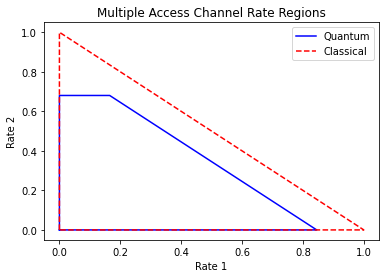


Uniform Priors Rate Region


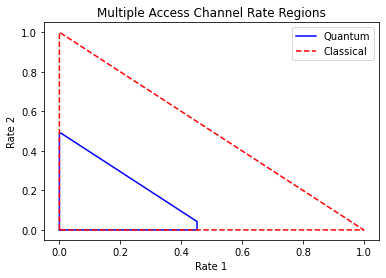


Quantum Communication MAC

iteration :  0 , score :  2.053752184044813
iteration :  25 , score :  3.5079774082122266
iteration :  50 , score :  4.299428015558671
iteration :  75 , score :  4.407374426442247
max score :  4.413631350704279
classical bound :  4
rate triple :  (0.6889194793030162, -4.440892098500626e-16, 0.6889194793030162)
priors tuple :  (tensor([0.4, 0. , 0.6], requires_grad=True), tensor([1., 0., 0.], requires_grad=True))

Max Rate Region


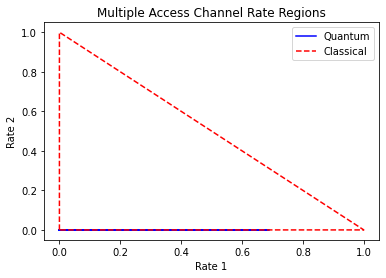


Uniform Priors Rate Region


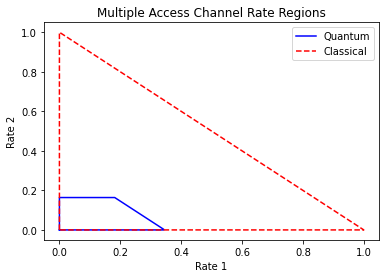


Entanglement-Assisted Classical MAC

iteration :  0 , score :  2.4471462962326833
iteration :  25 , score :  4.407622646750584
iteration :  50 , score :  4.413778225869101
iteration :  75 , score :  4.4141725753049
max score :  4.414209586589041
classical bound :  4
rate triple :  (0.6865751220967229, 0.0, 0.6865751220967229)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([1., 0., 0.], requires_grad=True))

Max Rate Region


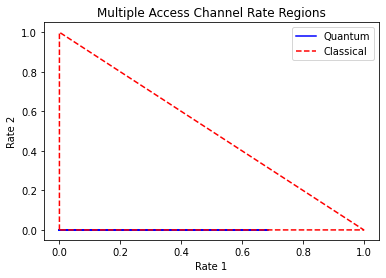


Uniform Priors Rate Region


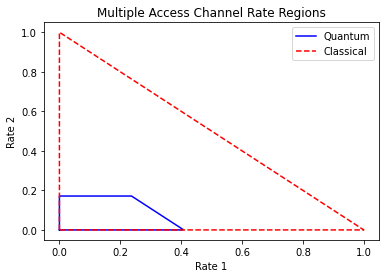

CPU times: user 1min 7s, sys: 559 ms, total: 1min 8s
Wall time: 1min 8s


In [19]:
%%time

inequality = mac_bound_inequalities[0]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 1

[[0 0 1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0 0 0]]  <=  4

Classical MAC

iteration :  0 , score :  2.2167104495947756
iteration :  25 , score :  3.9272962783037775
iteration :  50 , score :  3.999032584800918
iteration :  75 , score :  3.9999845676393293
max score :  3.9999996576754357
classical bound :  4
rate triple :  (0.9999969562607864, 0.9999969562607922, 0.9999969562607949)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


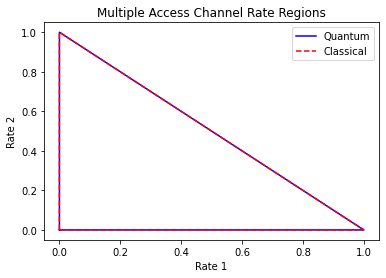


Uniform Priors Rate Region


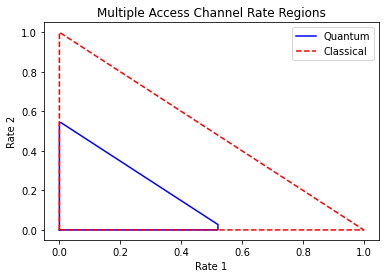


Quantum Communication MAC

iteration :  0 , score :  2.4684731566118567
iteration :  25 , score :  3.970096802538958
iteration :  50 , score :  4.051622882532878
iteration :  75 , score :  4.227284795765165
max score :  4.375291598488351
classical bound :  4
rate triple :  (-4.440892098500626e-16, 0.6778062708704327, 0.6778062708704327)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


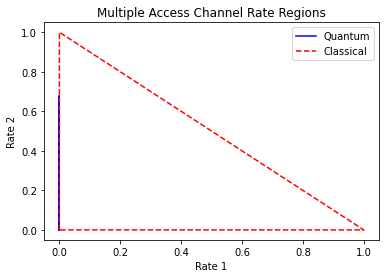


Uniform Priors Rate Region


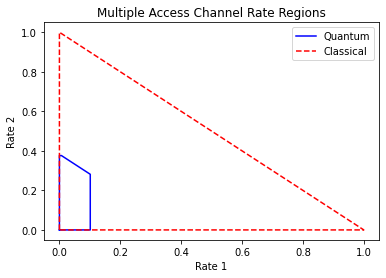


Entanglement-Assisted Classical MAC

iteration :  0 , score :  2.2195565844617766
iteration :  25 , score :  4.378048160259092
iteration :  50 , score :  4.412356043927402
iteration :  75 , score :  4.41405057158559
max score :  4.414198086863456
classical bound :  4
rate triple :  (2.220446049250313e-16, 0.6883117317887324, 0.6883117317887324)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


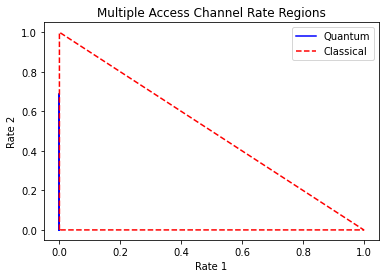


Uniform Priors Rate Region


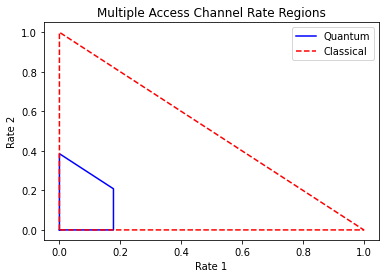

In [20]:
%%time

inequality = mac_bound_inequalities[1]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 2

[[0 0 0 0 0 1 1 0 0]
 [1 1 0 1 0 0 0 1 0]]  <=  5

Classical MAC

iteration :  0 , score :  2.1188742181736515
iteration :  25 , score :  4.954702881644859
iteration :  50 , score :  4.9996394425616755
iteration :  75 , score :  4.999991604753446
max score :  4.999999712357232
classical bound :  5
rate triple :  (2.220446049250313e-16, 0.999997167254093, 0.999997167254093)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


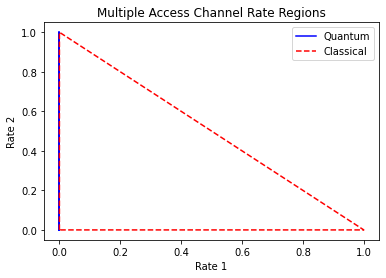


Uniform Priors Rate Region


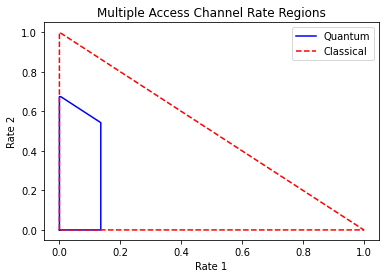


Quantum Communication MAC

iteration :  0 , score :  2.800563657079872
iteration :  25 , score :  5.054033714502685
iteration :  50 , score :  5.31674847824427
iteration :  75 , score :  5.329542157358856
max score :  5.332203855479372
classical bound :  5
rate triple :  (0.22516127664961427, 0.7843878184393906, 0.7856495713066725)
priors tuple :  (tensor([0. , 0.9, 0.1], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


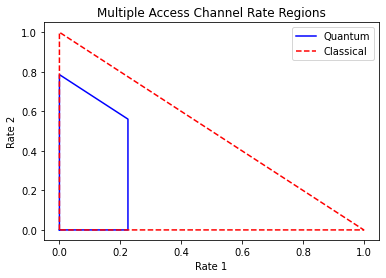


Uniform Priors Rate Region


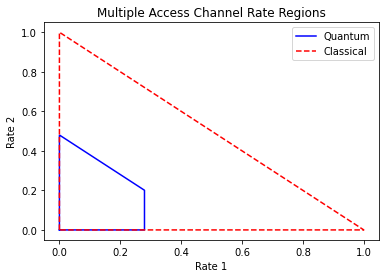


Entanglement-Assisted Classical MAC

iteration :  0 , score :  3.7422756541239144
iteration :  25 , score :  5.295328750396231
iteration :  50 , score :  5.3858583619804
iteration :  75 , score :  5.408514654658309
max score :  5.413122232783
classical bound :  5
rate triple :  (0.5498604259039159, 0.8833613718443822, 0.8833769735420516)
priors tuple :  (tensor([0. , 0.8, 0.2], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


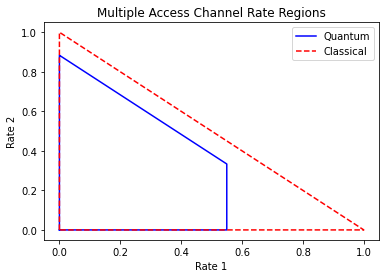


Uniform Priors Rate Region


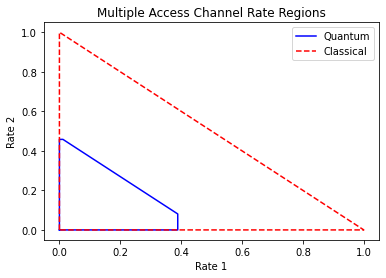

CPU times: user 1min 6s, sys: 503 ms, total: 1min 6s
Wall time: 1min 6s


In [21]:
%%time

inequality = mac_bound_inequalities[2]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 3

[[0 0 0 0 1 0 0 0 1]
 [1 1 0 1 0 1 0 0 0]]  <=  5

Classical MAC

iteration :  0 , score :  2.5042344073406273
iteration :  25 , score :  4.918621497569104
iteration :  50 , score :  4.990571368597658
iteration :  75 , score :  4.997841529432333
max score :  4.9994481830885755
classical bound :  5
rate triple :  (0.9902447906769223, 0.9902423437824242, 0.9902447906772718)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


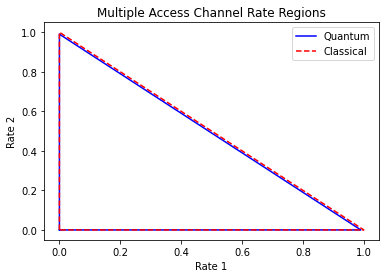


Uniform Priors Rate Region


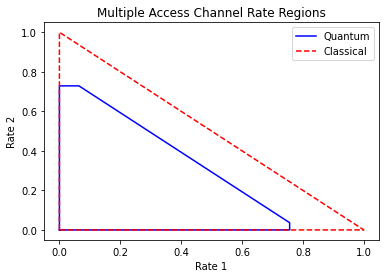


Quantum Communication MAC

iteration :  0 , score :  3.2126568474978727
iteration :  25 , score :  5.251282296978282
iteration :  50 , score :  5.29702030406292
iteration :  75 , score :  5.306394566140941
max score :  5.314474147912843
classical bound :  5
rate triple :  (0.7569448111254045, 0.21927695724740648, 0.7577230436802602)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.1, 0.9], requires_grad=True))

Max Rate Region


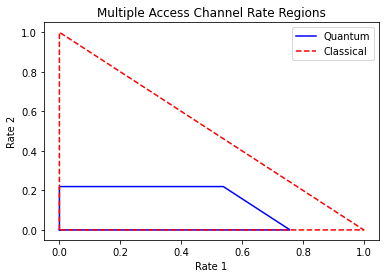


Uniform Priors Rate Region


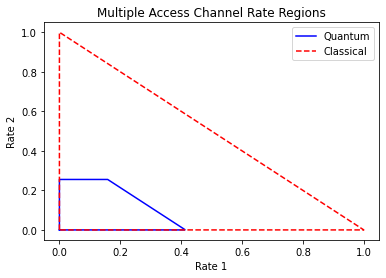


Entanglement-Assisted Classical MAC

iteration :  0 , score :  3.508789888887277
iteration :  25 , score :  5.195235006837853
iteration :  50 , score :  5.314235152754876
iteration :  75 , score :  5.347146441015889
max score :  5.369767667495463
classical bound :  5
rate triple :  (0.7949813174524167, 0.7929957144972062, 0.8300706750290421)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


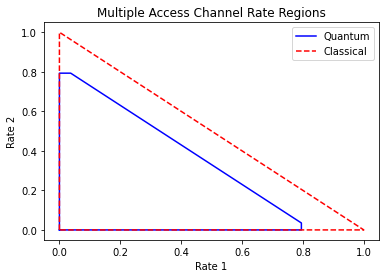


Uniform Priors Rate Region


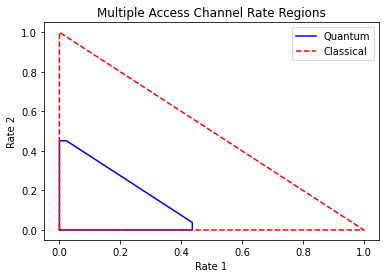

CPU times: user 1min 6s, sys: 495 ms, total: 1min 7s
Wall time: 1min 7s


In [22]:
%%time

inequality = mac_bound_inequalities[3]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 4

[[0 0 1 0 1 0 1 0 0]
 [2 1 0 1 0 1 0 1 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.186422848149135
iteration :  25 , score :  6.952252433161155
iteration :  50 , score :  6.990612701997604
iteration :  75 , score :  6.995884243579311
max score :  6.997789701066805
classical bound :  7
rate triple :  (0.9937552274977679, 0.9937544109276426, 0.9937552274977697)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


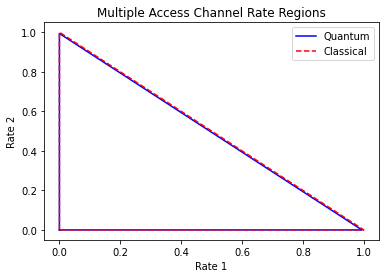


Uniform Priors Rate Region


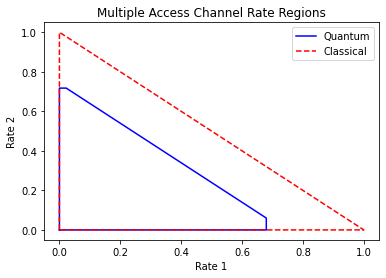


Quantum Communication MAC

iteration :  0 , score :  3.7513536586249887
iteration :  25 , score :  6.698030022469508
iteration :  50 , score :  6.905843731744531
iteration :  75 , score :  6.983007411761127
max score :  6.995944790032076
classical bound :  7
rate triple :  (0.9719731236587146, 0.971980654504208, 0.9719843575732998)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


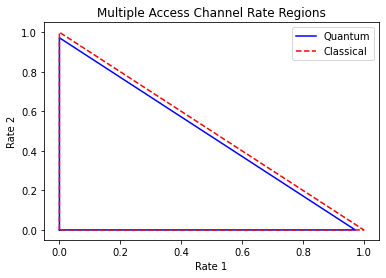


Uniform Priors Rate Region


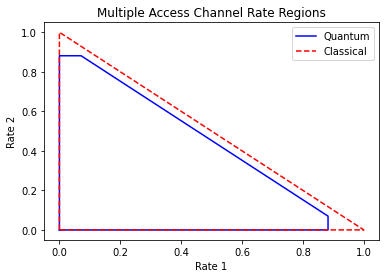


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.311672714050665
iteration :  25 , score :  7.723698339779707
iteration :  50 , score :  7.774878946848019
iteration :  75 , score :  7.776979489193332
max score :  7.777218839607007
classical bound :  7
rate triple :  (0.5877094551198021, 0.5035484365688965, 0.6301753039817979)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.7, 0.3], requires_grad=True))

Max Rate Region


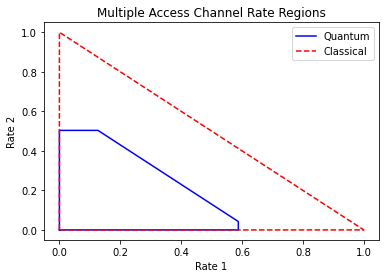


Uniform Priors Rate Region


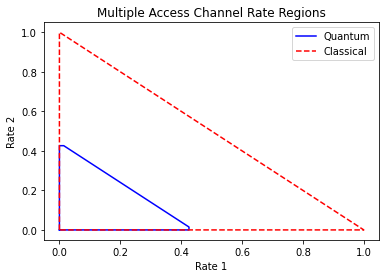

CPU times: user 1min 6s, sys: 521 ms, total: 1min 7s
Wall time: 1min 7s


In [23]:
%%time

inequality = mac_bound_inequalities[4]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 5

[[0 0 1 0 1 0 1 0 0]
 [2 2 0 1 0 0 0 1 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.358659323835035
iteration :  25 , score :  6.973654185476647
iteration :  50 , score :  6.994866781905723
iteration :  75 , score :  6.998592474521654
max score :  6.999583098147616
classical bound :  7
rate triple :  (2.220446049250313e-16, 0.9997535246353033, 0.9997535246353033)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


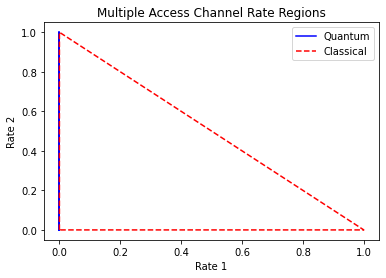


Uniform Priors Rate Region


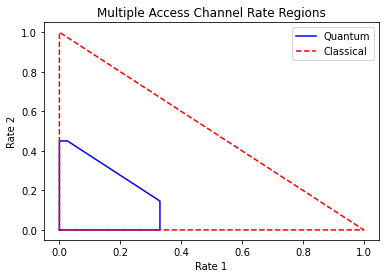


Quantum Communication MAC

iteration :  0 , score :  4.966048592677049
iteration :  25 , score :  6.136032052467541
iteration :  50 , score :  6.8461859618417815
iteration :  75 , score :  6.9936612263563385
max score :  6.9990038318013506
classical bound :  7
rate triple :  (2.220446049250313e-16, 0.9947972248527073, 0.9947972248527073)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


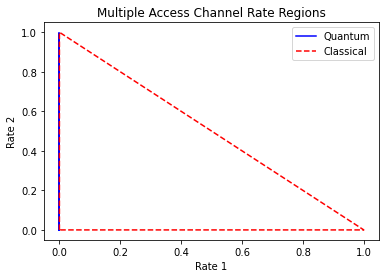


Uniform Priors Rate Region


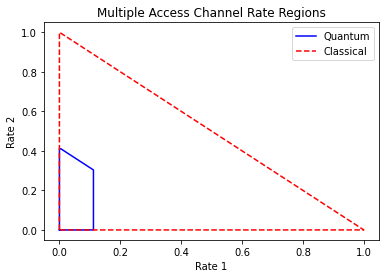


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.556153492253626
iteration :  25 , score :  7.806434022321858
iteration :  50 , score :  7.827434431153314
iteration :  75 , score :  7.828357842113519
max score :  7.828417540140493
classical bound :  7
rate triple :  (0.1725980408533314, 0.6268963629896538, 0.6269713800164904)
priors tuple :  (tensor([0.9, 0. , 0.1], requires_grad=True), tensor([0.4, 0. , 0.6], requires_grad=True))

Max Rate Region


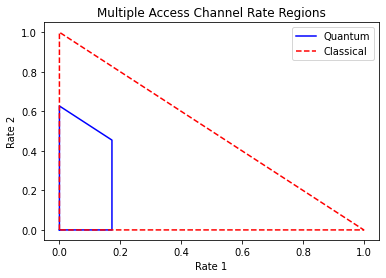


Uniform Priors Rate Region


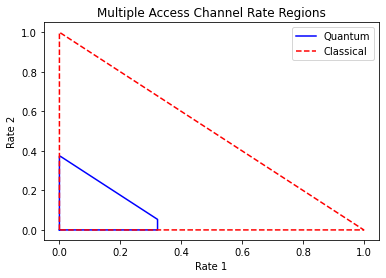

CPU times: user 1min 7s, sys: 526 ms, total: 1min 7s
Wall time: 1min 7s


In [24]:
%%time

inequality = mac_bound_inequalities[5]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 6

[[0 0 1 0 1 0 1 0 0]
 [2 1 0 2 0 1 0 0 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.560058586850083
iteration :  25 , score :  6.768897768769276
iteration :  50 , score :  6.991204273745181
iteration :  75 , score :  6.998655439372778
max score :  6.999705819034374
classical bound :  7
rate triple :  (0.9496853824776852, 0.9495625777157115, 0.9496853827919116)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


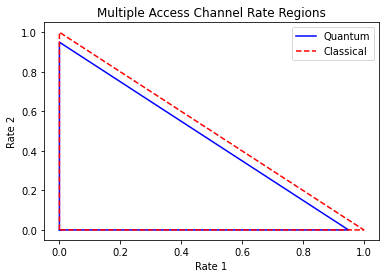


Uniform Priors Rate Region


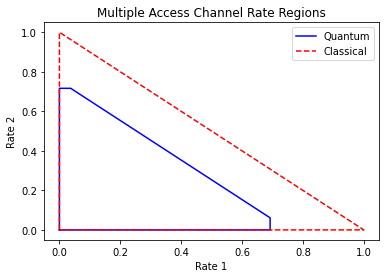


Quantum Communication MAC

iteration :  0 , score :  4.116106789458756
iteration :  25 , score :  7.254675965567063
iteration :  50 , score :  7.299177175813969
iteration :  75 , score :  7.30787526178564
max score :  7.309196387969599
classical bound :  7
rate triple :  (0.852570222157105, 0.2559973162441971, 0.8533708934148609)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0. , 0.9, 0.1], requires_grad=True))

Max Rate Region


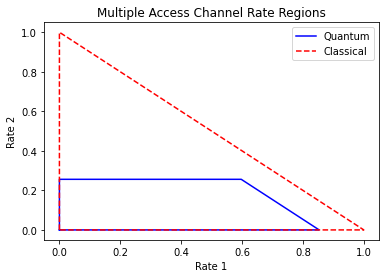


Uniform Priors Rate Region


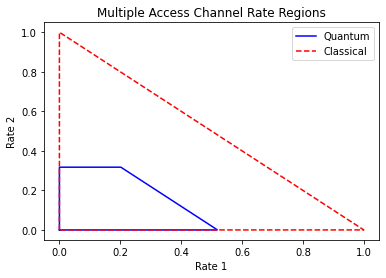


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.22514332449743
iteration :  25 , score :  7.808711640096682
iteration :  50 , score :  7.827348779383501
iteration :  75 , score :  7.828244385278559
max score :  7.8283123134713515
classical bound :  7
rate triple :  (0.6260824893169108, 0.17087474578710604, 0.626143489404166)
priors tuple :  (tensor([0.4, 0. , 0.6], requires_grad=True), tensor([0.9, 0. , 0.1], requires_grad=True))

Max Rate Region


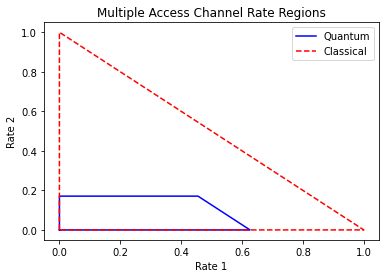


Uniform Priors Rate Region


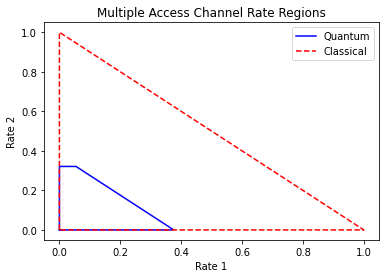

CPU times: user 1min 10s, sys: 527 ms, total: 1min 11s
Wall time: 1min 11s


In [25]:
%%time

inequality = mac_bound_inequalities[6]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 7

[[0 0 0 0 1 1 1 0 1]
 [1 1 0 1 0 0 0 1 0]]  <=  6

Classical MAC

iteration :  0 , score :  4.082769586601683
iteration :  25 , score :  5.690545259408648
iteration :  50 , score :  5.904948779027786
iteration :  75 , score :  5.962588698240788
max score :  5.983240320150281
classical bound :  6
rate triple :  (0.0, 0.9915961282900003, 0.9915961282900003)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


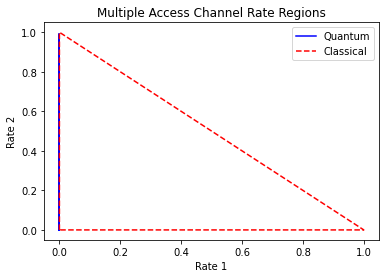


Uniform Priors Rate Region


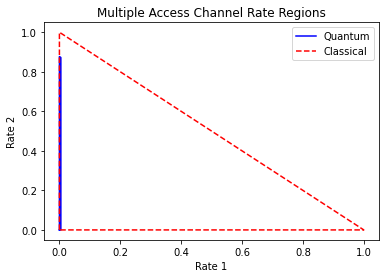


Quantum Communication MAC

iteration :  0 , score :  4.0839353411463035
iteration :  25 , score :  6.338481777712102
iteration :  50 , score :  6.488810075943636
iteration :  75 , score :  6.4994164340525336
max score :  6.499947571419175
classical bound :  6
rate triple :  (0.4586314825986264, 0.4586318299794998, 0.4586319634009466)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


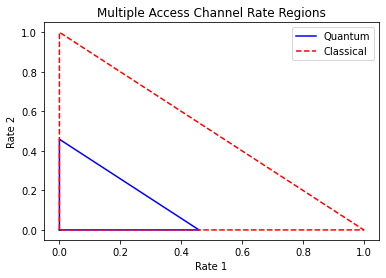


Uniform Priors Rate Region


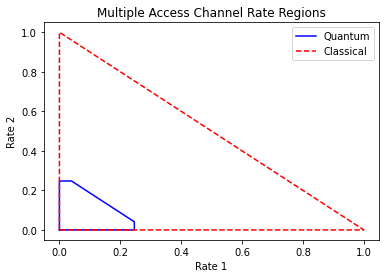


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.1424486837711525
iteration :  25 , score :  6.412024730717154
iteration :  50 , score :  6.495199319294338
iteration :  75 , score :  6.499787917552157
max score :  6.49999135140124
classical bound :  6
rate triple :  (0.458875281235422, 0.4588750321899, 0.4588753421203795)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


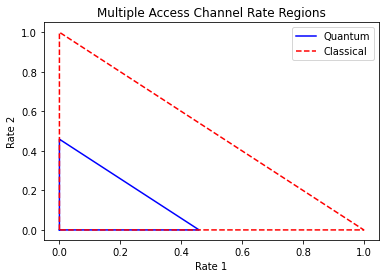


Uniform Priors Rate Region


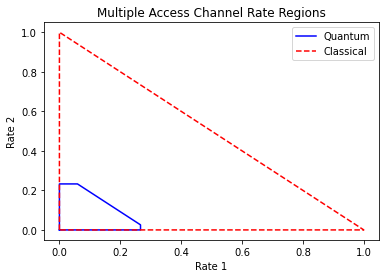

CPU times: user 1min 17s, sys: 809 ms, total: 1min 17s
Wall time: 1min 18s


In [26]:
%%time

inequality = mac_bound_inequalities[7]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 8

[[0 0 0 0 1 1 2 0 0]
 [2 2 0 1 0 0 0 1 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.106669382569539
iteration :  25 , score :  7.961346470925131
iteration :  50 , score :  7.996291056146019
iteration :  75 , score :  7.9995002522269445
max score :  7.999893558441835
classical bound :  8
rate triple :  (0.9998481391457879, 0.9998481390645209, 0.9998481391464118)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


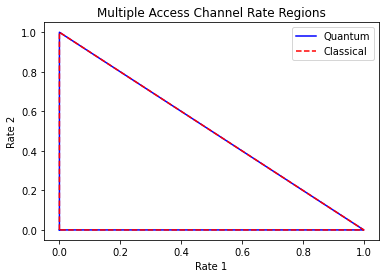


Uniform Priors Rate Region


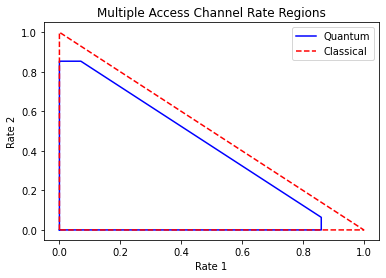


Quantum Communication MAC

iteration :  0 , score :  5.015292109824237
iteration :  25 , score :  8.302691322973567
iteration :  50 , score :  8.644749205802604
iteration :  75 , score :  8.670766876922157
max score :  8.67323934751774
classical bound :  8
rate triple :  (0.5046958286260881, 0.5046958441085145, 0.5046958445180056)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


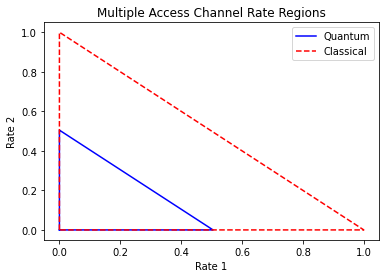


Uniform Priors Rate Region


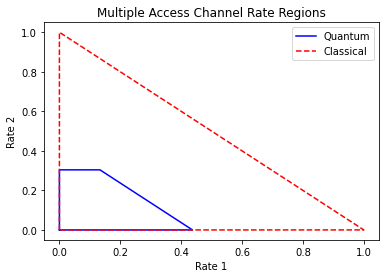


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.3495747512007945
iteration :  25 , score :  8.648487543032704
iteration :  50 , score :  8.732632363651524
iteration :  75 , score :  8.742810288974258
max score :  8.744730692760443
classical bound :  8
rate triple :  (0.8020460396939582, 0.662157478511785, 0.8025548100404816)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.3, 0. , 0.7], requires_grad=True))

Max Rate Region


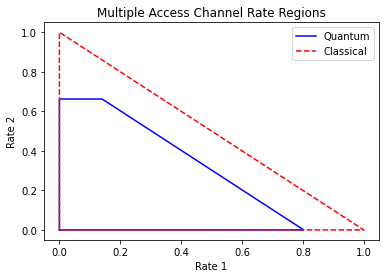


Uniform Priors Rate Region


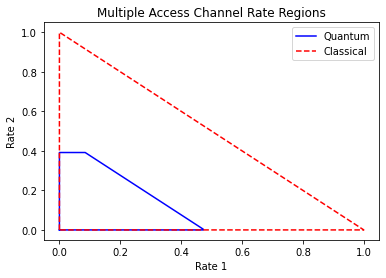

CPU times: user 1min 19s, sys: 903 ms, total: 1min 20s
Wall time: 1min 20s


In [27]:
%%time

inequality = mac_bound_inequalities[8]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 9

[[0 0 0 0 2 0 1 0 1]
 [2 2 0 1 0 1 0 0 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.0650615157342385
iteration :  25 , score :  7.963381556040443
iteration :  50 , score :  7.999054976242238
iteration :  75 , score :  7.999973753102454
max score :  7.999999254402673
classical bound :  8
rate triple :  (0.9075958452333248, 0.2587289709446754, 0.9075958452333266)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.8, 0.1, 0.1], requires_grad=True))

Max Rate Region


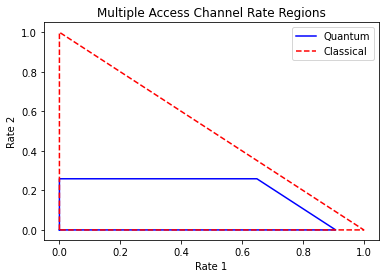


Uniform Priors Rate Region


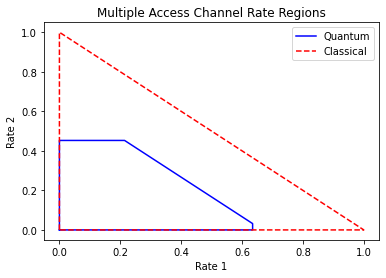


Quantum Communication MAC

iteration :  0 , score :  4.5249826464645455
iteration :  25 , score :  8.807824278377472
iteration :  50 , score :  8.827632077723152
iteration :  75 , score :  8.828303616834116
max score :  8.828391102967993
classical bound :  8
rate triple :  (0.6273062297293932, 0.173432240589124, 0.6273902141706755)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0. , 0.1, 0.9], requires_grad=True))

Max Rate Region


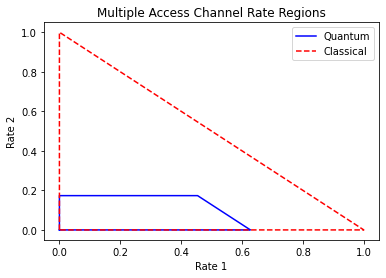


Uniform Priors Rate Region


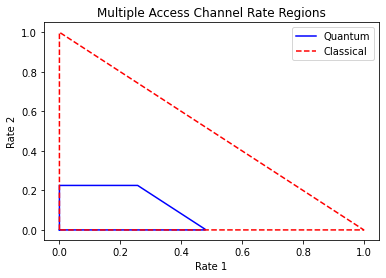


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.871994274503107
iteration :  25 , score :  8.92135363558766
iteration :  50 , score :  8.958508260448395
iteration :  75 , score :  8.95880444704715
max score :  8.958818837343285
classical bound :  8
rate triple :  (0.6471593582607302, 0.3668308446345372, 0.688410495212191)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.2, 0.8], requires_grad=True))

Max Rate Region


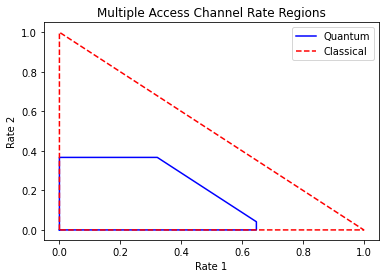


Uniform Priors Rate Region


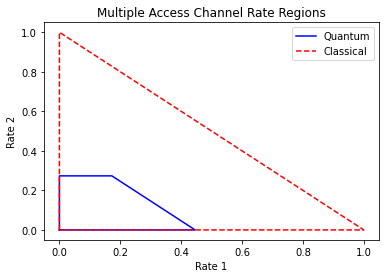

CPU times: user 1min 14s, sys: 632 ms, total: 1min 15s
Wall time: 1min 15s


In [28]:
%%time

inequality = mac_bound_inequalities[9]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 10

[[0 0 1 0 2 0 0 0 1]
 [2 1 0 2 0 1 0 0 0]]  <=  8

Classical MAC

iteration :  0 , score :  6.118640618174729
iteration :  25 , score :  7.973364264552964
iteration :  50 , score :  7.999037729356461
iteration :  75 , score :  7.999876182473315
max score :  7.999978587549847
classical bound :  8
rate triple :  (0.9998306350262163, 0.9998306352739461, 0.9998306352740398)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


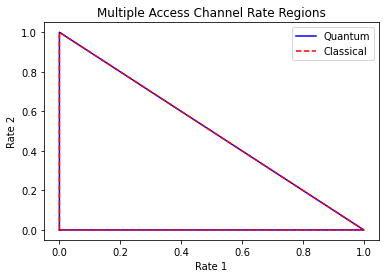


Uniform Priors Rate Region


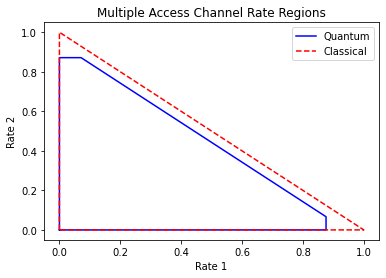


Quantum Communication MAC

iteration :  0 , score :  5.218413970723923
iteration :  25 , score :  8.640217759025902
iteration :  50 , score :  8.66685333350611
iteration :  75 , score :  8.672226078198355
max score :  8.673641684458664
classical bound :  8
rate triple :  (0.5059692514898462, 0.5059692353839509, 0.5059692515031546)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


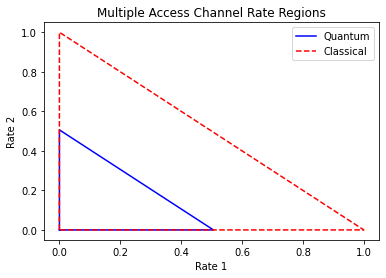


Uniform Priors Rate Region


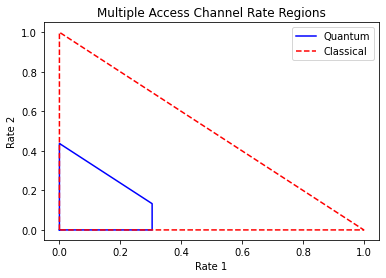


Entanglement-Assisted Classical MAC

iteration :  0 , score :  6.014154967107225
iteration :  25 , score :  8.301598490832603
iteration :  50 , score :  8.706530501569425
iteration :  75 , score :  8.741813502670185
max score :  8.744764961321001
classical bound :  8
rate triple :  (0.7017613147840707, 0.8460306573517586, 0.8464911354754197)
priors tuple :  (tensor([0. , 0.3, 0.7], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


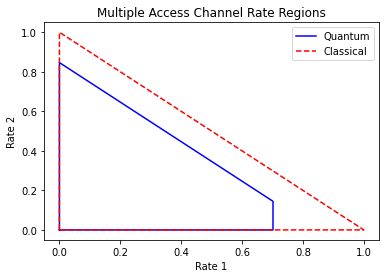


Uniform Priors Rate Region


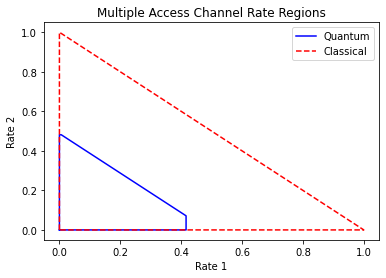

CPU times: user 1min 3s, sys: 326 ms, total: 1min 3s
Wall time: 1min 3s


In [29]:
%%time

inequality = mac_bound_inequalities[10]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 11

[[0 0 1 0 2 0 0 0 1]
 [2 1 0 2 0 0 0 1 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.438716263006258
iteration :  25 , score :  7.990309397109472
iteration :  50 , score :  7.999420973953717
iteration :  75 , score :  7.99976771817475
max score :  7.999894606269014
classical bound :  8
rate triple :  (0.5568770878762135, 0.8893759244900683, 0.8893759244931974)
priors tuple :  (tensor([0.7, 0.2, 0.1], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


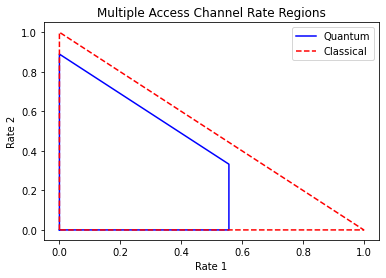


Uniform Priors Rate Region


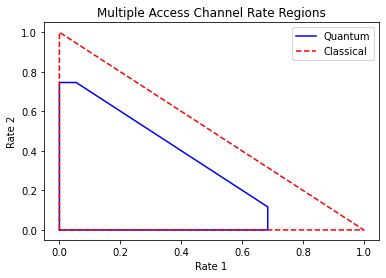


Quantum Communication MAC

iteration :  0 , score :  4.786536010033585
iteration :  25 , score :  8.08020206666203
iteration :  50 , score :  8.286377853590338
iteration :  75 , score :  8.406007672639868
max score :  8.416093965904569
classical bound :  8
rate triple :  (0.08699753665932208, 0.6016411184236954, 0.6225586748312495)
priors tuple :  (tensor([0. , 0.9, 0.1], requires_grad=True), tensor([0.6, 0. , 0.4], requires_grad=True))

Max Rate Region


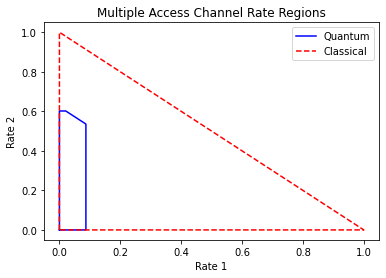


Uniform Priors Rate Region


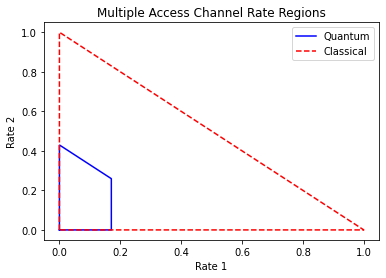


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.71350578534485
iteration :  25 , score :  8.942984524408706
iteration :  50 , score :  8.955214802621953
iteration :  75 , score :  8.716816542471443
max score :  8.922426417980597
classical bound :  8
rate triple :  (0.374269339174349, 0.6780330616473895, 0.6850150232984449)
priors tuple :  (tensor([0. , 0.2, 0.8], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


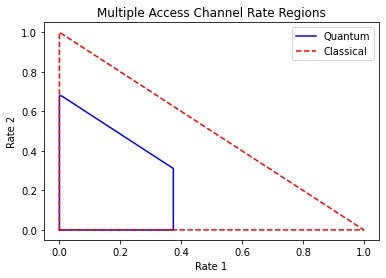


Uniform Priors Rate Region


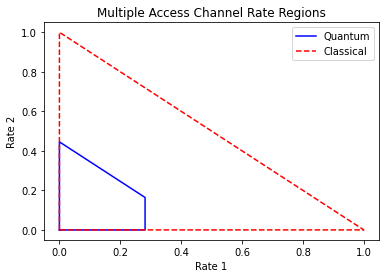

CPU times: user 1min 7s, sys: 341 ms, total: 1min 7s
Wall time: 1min 7s


In [30]:
%%time

inequality = mac_bound_inequalities[11]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 12

[[0 0 1 0 1 0 2 0 0]
 [2 1 0 0 0 1 0 2 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.05339921414238
iteration :  25 , score :  7.910468696786473
iteration :  50 , score :  7.997284773006325
iteration :  75 , score :  7.998820598173294
max score :  7.999392223214782
classical bound :  8
rate triple :  (0.9999273761781322, 0.999927376198742, 0.9999273761989871)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


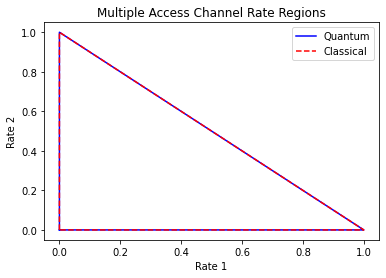


Uniform Priors Rate Region


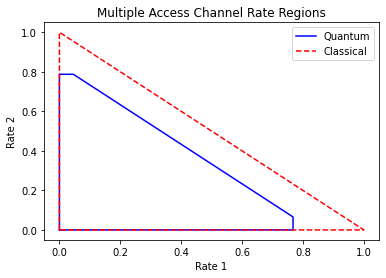


Quantum Communication MAC

iteration :  0 , score :  4.087275504564335
iteration :  25 , score :  7.980908604722858
iteration :  50 , score :  7.998681770212361
iteration :  75 , score :  7.999861813376313
max score :  8.00081390933568
classical bound :  8
rate triple :  (0.9904520210901886, 0.9904520318249679, 0.9904520319045838)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


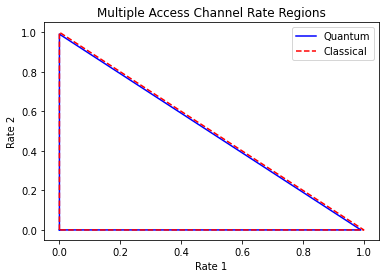


Uniform Priors Rate Region


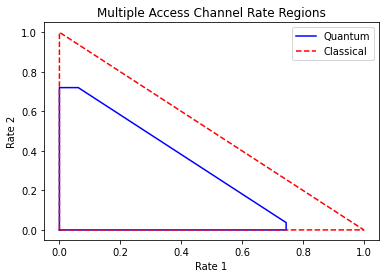


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.785918178252221
iteration :  25 , score :  8.775269737590937
iteration :  50 , score :  8.95556921597093
iteration :  75 , score :  8.958681614729642
max score :  8.958812821901498
classical bound :  8
rate triple :  (0.6787842371015911, 0.5377690070136127, 0.6877996430304449)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.3, 0.7], requires_grad=True))

Max Rate Region


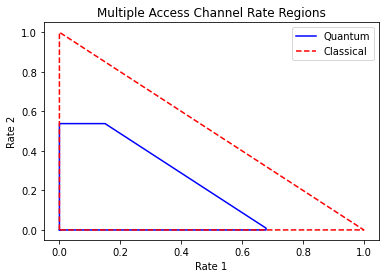


Uniform Priors Rate Region


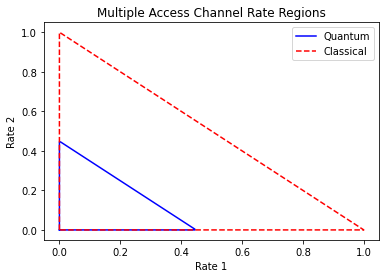

CPU times: user 1min 11s, sys: 441 ms, total: 1min 11s
Wall time: 1min 11s


In [31]:
%%time

inequality = mac_bound_inequalities[12]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 13

[[0 0 1 0 2 0 1 0 1]
 [3 2 0 2 0 1 0 0 0]]  <=  10

Classical MAC

iteration :  0 , score :  4.921018834022846
iteration :  25 , score :  9.992505962241344
iteration :  50 , score :  9.999952739353352
iteration :  75 , score :  9.999999568507683
max score :  9.99999999584256
classical bound :  10
rate triple :  (0.9999999988016601, 2.220446049250313e-16, 0.9999999988016601)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([1., 0., 0.], requires_grad=True))

Max Rate Region


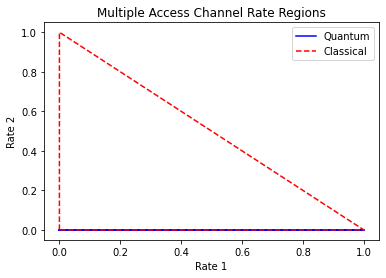


Uniform Priors Rate Region


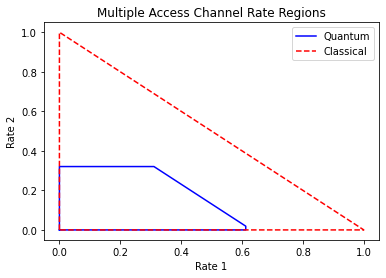


Quantum Communication MAC

iteration :  0 , score :  7.369755179167186
iteration :  25 , score :  10.538918151002138
iteration :  50 , score :  10.553319815038934
iteration :  75 , score :  10.555307612757444
max score :  10.555696514457413
classical bound :  10
rate triple :  (0.6035128554195737, 0.6386652581176646, 0.6387189131244537)
priors tuple :  (tensor([0.5, 0.4, 0.1], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


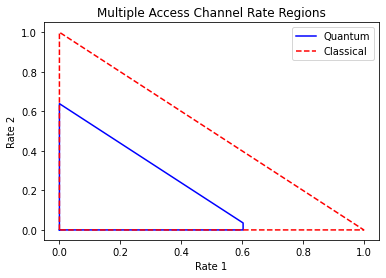


Uniform Priors Rate Region


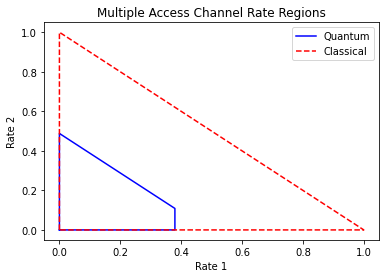


Entanglement-Assisted Classical MAC

iteration :  0 , score :  6.2827048416667
iteration :  25 , score :  11.15695683166396
iteration :  50 , score :  11.18107909062216
iteration :  75 , score :  11.181329410819332
max score :  11.181332255158198
classical bound :  10
rate triple :  (0.5741318672726963, 0.4823802227069174, 0.61094443096539)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.3, 0.7], requires_grad=True))

Max Rate Region


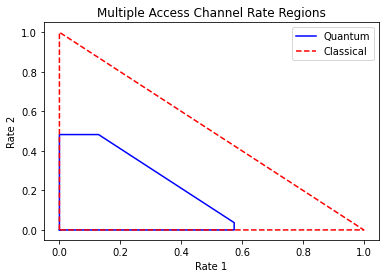


Uniform Priors Rate Region


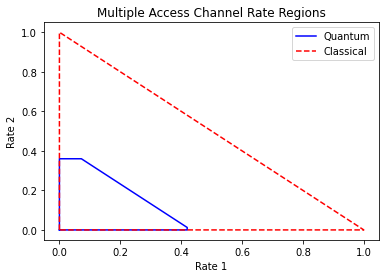

CPU times: user 1min 4s, sys: 341 ms, total: 1min 4s
Wall time: 1min 4s


In [32]:
%%time

inequality = mac_bound_inequalities[13]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 14

[[0 0 1 0 2 0 1 0 1]
 [3 2 0 2 0 0 0 1 0]]  <=  10

Classical MAC

iteration :  0 , score :  6.9317216021091825
iteration :  25 , score :  9.975326511995496
iteration :  50 , score :  9.999639767479472
iteration :  75 , score :  9.99999485815243
max score :  9.999999927221237
classical bound :  10
rate triple :  (0.9999997685639008, 0.9999997685639008, 0.9999997685639026)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


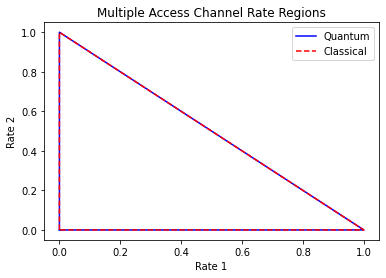


Uniform Priors Rate Region


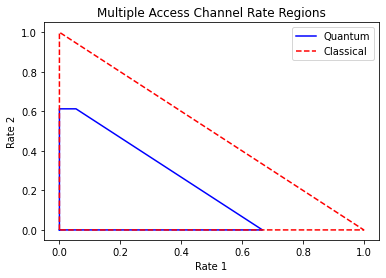


Quantum Communication MAC

iteration :  0 , score :  4.916243412628908
iteration :  25 , score :  10.485314285743618
iteration :  50 , score :  10.681862098678602
iteration :  75 , score :  10.721939254163464
max score :  10.725727179972818
classical bound :  10
rate triple :  (0.21070557030402326, 0.7422369616517843, 0.744135215567572)
priors tuple :  (tensor([0. , 0.1, 0.9], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


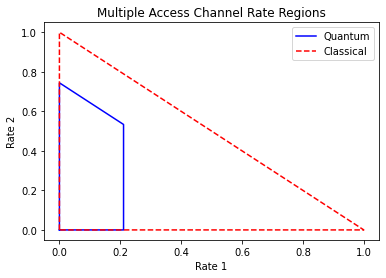


Uniform Priors Rate Region


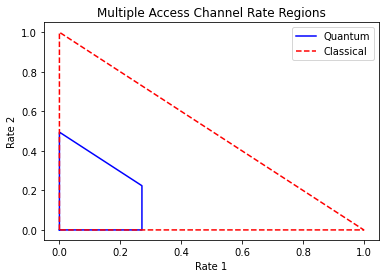


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.54046708980013
iteration :  25 , score :  11.166699078332348
iteration :  50 , score :  11.18087640095756
iteration :  75 , score :  11.18128676322179
max score :  11.18132491506507
classical bound :  10
rate triple :  (0.48271676899547167, 0.5746650694735038, 0.6114925991267453)
priors tuple :  (tensor([0. , 0.3, 0.7], requires_grad=True), tensor([0. , 0.6, 0.4], requires_grad=True))

Max Rate Region


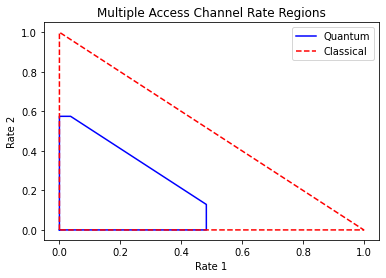


Uniform Priors Rate Region


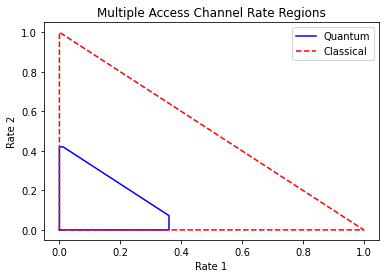

CPU times: user 1min 4s, sys: 419 ms, total: 1min 5s
Wall time: 1min 5s


In [33]:
%%time

inequality = mac_bound_inequalities[14]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 15

[[0 0 2 0 1 0 2 0 0]
 [3 1 0 1 0 2 0 2 0]]  <=  11

Classical MAC

iteration :  0 , score :  7.734251289741115
iteration :  25 , score :  10.979548884014264
iteration :  50 , score :  10.99714978371269
iteration :  75 , score :  10.999652052720919
max score :  10.999961130001518
classical bound :  11
rate triple :  (0.9999804136794568, 0.9999804136794448, 0.9999804136794586)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


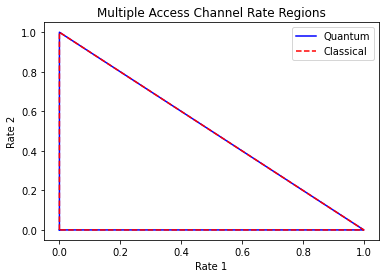


Uniform Priors Rate Region


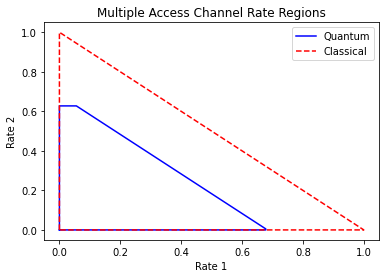


Quantum Communication MAC

iteration :  0 , score :  8.076797175456186
iteration :  25 , score :  11.139571018103839
iteration :  50 , score :  11.140326912176782
iteration :  75 , score :  11.1403418346003
max score :  11.140343026828127
classical bound :  11
rate triple :  (0.8658934811778387, 0.8335880889871135, 0.8659099088172004)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


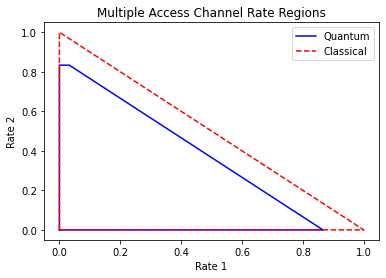


Uniform Priors Rate Region


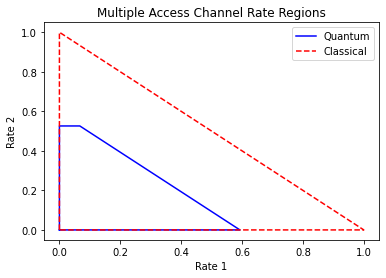


Entanglement-Assisted Classical MAC

iteration :  0 , score :  7.936085523315972
iteration :  25 , score :  12.273490132958631
iteration :  50 , score :  12.275853872636953
iteration :  75 , score :  12.27578140498111
max score :  12.275614022401648
classical bound :  11
rate triple :  (0.5700937707044278, 0.5701169941798208, 0.7104137045680745)
priors tuple :  (tensor([0. , 0.7, 0.3], requires_grad=True), tensor([0. , 0.7, 0.3], requires_grad=True))

Max Rate Region


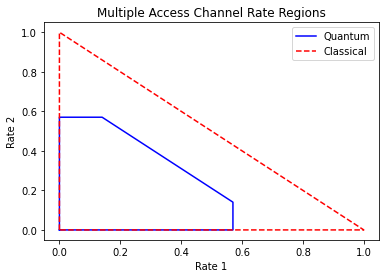


Uniform Priors Rate Region


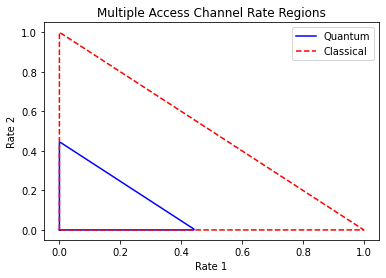

CPU times: user 1min 4s, sys: 350 ms, total: 1min 4s
Wall time: 1min 4s


In [34]:
%%time

inequality = mac_bound_inequalities[15]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality  16

[[0 0 2 0 2 0 2 0 0]
 [3 1 0 1 0 3 0 3 1]]  <=  14

Classical MAC

iteration :  0 , score :  8.140516634892421
iteration :  25 , score :  13.966961097037927
iteration :  50 , score :  13.996827506350236
iteration :  75 , score :  13.999442000646537
max score :  13.999892016134162
classical bound :  14
rate triple :  (0.9999927037635534, 0.9999927037636098, 0.9999927037636107)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


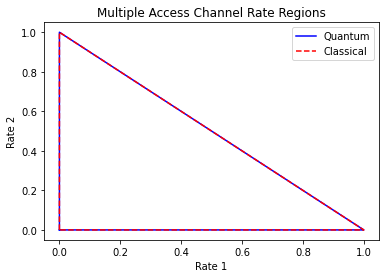


Uniform Priors Rate Region


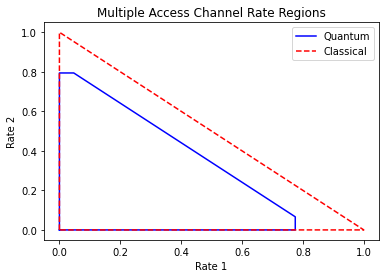


Quantum Communication MAC

iteration :  0 , score :  7.2875220574715245
iteration :  25 , score :  14.00484338779453
iteration :  50 , score :  13.742401058587891
iteration :  75 , score :  14.092093762114905
max score :  14.114225402077874
classical bound :  14
rate triple :  (0.8858793385444921, 0.8858876432285445, 0.885889351893355)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


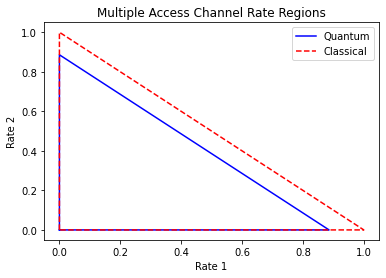


Uniform Priors Rate Region


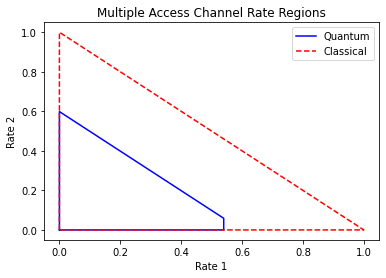


Entanglement-Assisted Classical MAC

iteration :  0 , score :  9.263834283439792
iteration :  25 , score :  14.730691873035248
iteration :  50 , score :  15.385937450907903
iteration :  75 , score :  15.440432960204088
max score :  15.474192412322028
classical bound :  14
rate triple :  (0.42192597527829934, 0.5114923290483033, 0.5692215273050247)
priors tuple :  (tensor([0.7, 0. , 0.3], requires_grad=True), tensor([0.6, 0. , 0.4], requires_grad=True))

Max Rate Region


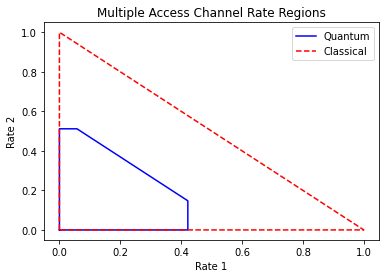


Uniform Priors Rate Region


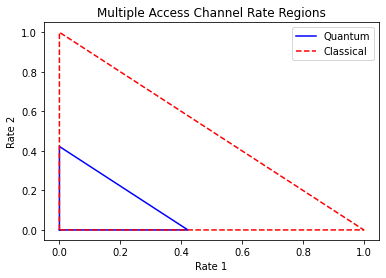

CPU times: user 1min 8s, sys: 571 ms, total: 1min 8s
Wall time: 1min 8s


In [35]:
%%time

inequality = mac_bound_inequalities[16]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 17

[[0 0 2 0 3 0 2 0 1]
 [5 3 0 3 0 1 0 1 0]]  <=  16

Classical MAC

iteration :  0 , score :  11.0952099779165
iteration :  25 , score :  15.968461380385342
iteration :  50 , score :  15.998730975909941
iteration :  75 , score :  15.999942598759525
max score :  15.999997474581036
classical bound :  16
rate triple :  (0.99999325299689, 0.9999932529971352, 0.9999932529971369)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


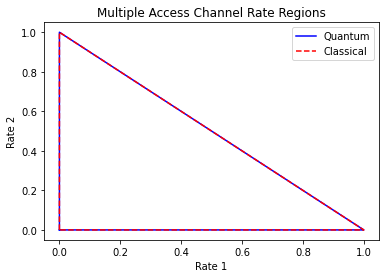


Uniform Priors Rate Region


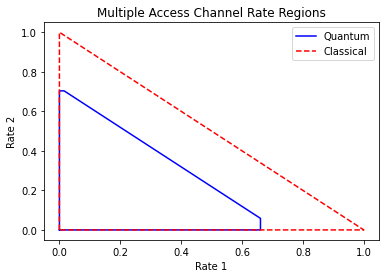


Quantum Communication MAC

iteration :  0 , score :  11.015259770282208
iteration :  25 , score :  15.773374418766021
iteration :  50 , score :  16.33203451742658
iteration :  75 , score :  16.61559529210757
max score :  16.65688945451774
classical bound :  16
rate triple :  (0.5610303853142993, 0.5301430452677902, 0.5611359329975181)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.4, 0.1], requires_grad=True))

Max Rate Region


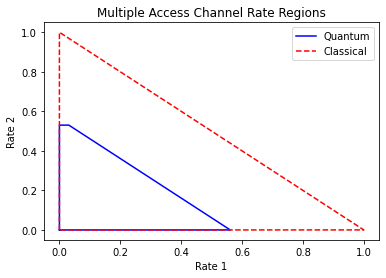


Uniform Priors Rate Region


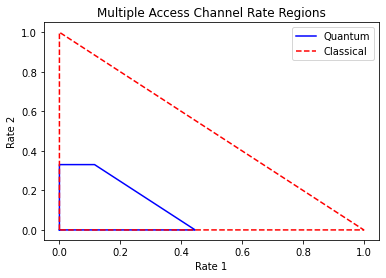


Entanglement-Assisted Classical MAC

iteration :  0 , score :  9.39269470185031
iteration :  25 , score :  15.89566858687106
iteration :  50 , score :  16.963120762471284
iteration :  75 , score :  16.991668312144892
max score :  17.899014341448712
classical bound :  16
rate triple :  (0.46328158018834475, 0.46401296916976875, 0.4875899298912958)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.6, 0.4], requires_grad=True))

Max Rate Region


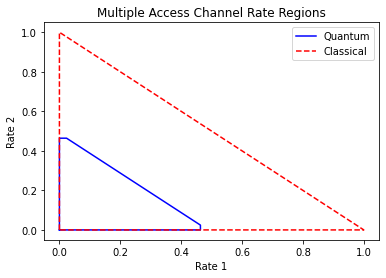


Uniform Priors Rate Region


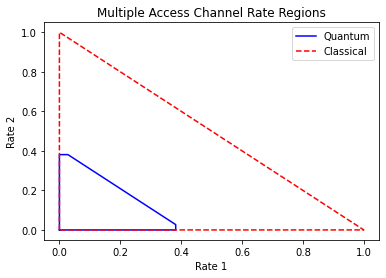

CPU times: user 1min 23s, sys: 862 ms, total: 1min 24s
Wall time: 1min 24s


In [36]:
%%time

inequality = mac_bound_inequalities[17]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 18

[[0 0 2 1 2 0 5 0 1]
 [4 2 0 0 0 1 0 4 0]]  <=  17

Classical MAC

iteration :  0 , score :  9.294080593777924
iteration :  25 , score :  16.988661574312943
iteration :  50 , score :  16.99796043168536
iteration :  75 , score :  16.999077027008134
max score :  16.999466104330438
classical bound :  17
rate triple :  (0.9999463171411707, 0.9999463171542331, 0.9999463171549907)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


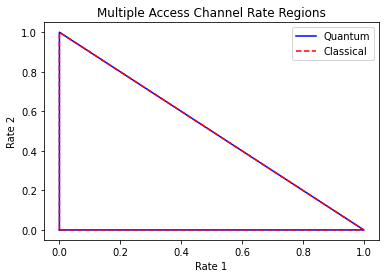


Uniform Priors Rate Region


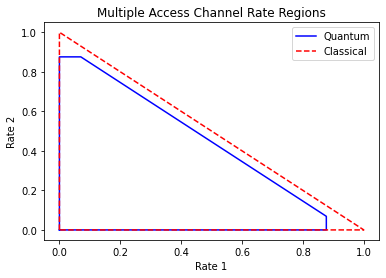


Quantum Communication MAC

iteration :  0 , score :  9.084361645733155
iteration :  25 , score :  16.66590599967176
iteration :  50 , score :  16.43235351707064
iteration :  75 , score :  17.12681197486412
max score :  17.314361581587047
classical bound :  17
rate triple :  (0.6519186708469915, 0.6953070912056223, 0.696709092253256)
priors tuple :  (tensor([0.6, 0.3, 0.1], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


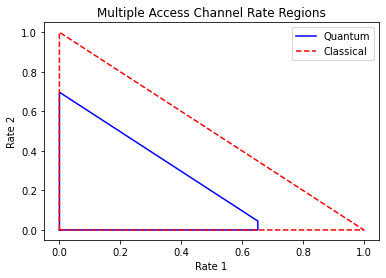


Uniform Priors Rate Region


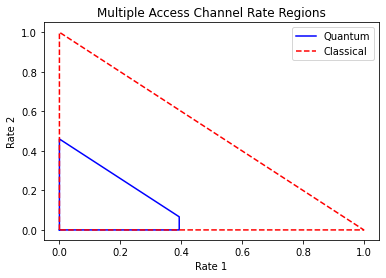


Entanglement-Assisted Classical MAC

iteration :  0 , score :  12.388233683788856
iteration :  25 , score :  17.893144699914973
iteration :  50 , score :  17.586322731808377
iteration :  75 , score :  18.394564758467993
max score :  18.599672732062256
classical bound :  17
rate triple :  (0.5386597445563375, 0.573007320714602, 0.5732969276866049)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


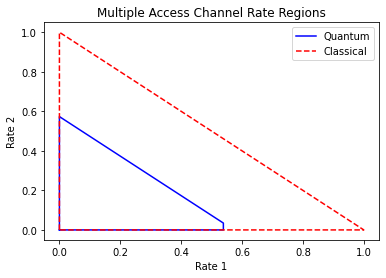


Uniform Priors Rate Region


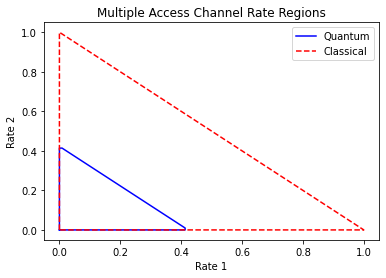

CPU times: user 1min 8s, sys: 465 ms, total: 1min 8s
Wall time: 1min 8s


In [37]:
%%time

inequality = mac_bound_inequalities[18]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)